In [1]:
# import pandas as pd
import pandas as pd
import math
import numpy as np

def parse_file(file_path):
    cells_started = False
    with open(file_path, "r") as file:
        lines = file.readlines()
    
    nodes = {}
    edges = {}
    cellss={}
    current_section = None
    for line in lines:
        line = line.strip()
        if not line:  # If the line is empty, reset the current section
            current_section = None
        elif "BEGIN_" in line:
            if "BEGIN_NODES" in line:
                current_section = "nodes"
            elif "BEGIN_EDGEGROUPS" in line:
                current_section = "edges"
            elif "BEGIN_ELEMENTS" in line:
                current_section = "cells"
        elif current_section:
            parts = line.split('\t')
            if current_section == "nodes":
                node_id = int(parts[0])
                if node_id != 0:  # Excluding nodes with ID 0
                    x_pos = float(parts[1])
                    y_pos = float(parts[2])
                    nodes[node_id] = (x_pos, -y_pos)
            elif current_section == "edges":
                edge_id = int(parts[0])
                if edge_id < 1000:  # Excluding edges with ID above 1000
                    node_1 = int(parts[1].split()[0])  # Parsing only the first node
                    node_2 = int(parts[1].split()[1])  # Parsing only the second node 
                    
                    cell_1 = int(parts[2].split()[0])  # Parsing the x position of the edge midpoint
                    cell_2 = int(parts[2].split()[1])  # Parsing the y position of the edge midpoint
                    
                    mid_x_pos = float(parts[3].split()[1])  # Parsing the x position of the edge midpoint
                    mid_y_pos = -float(parts[3].split()[2])  # Parsing the y position of the edge midpoint
                    edges[edge_id] = (node_1, node_2, mid_x_pos, mid_y_pos, cell_1, cell_2)
                    
            elif current_section == "cells":
                
                if not line.startswith(' '):
                    cells = parts[0]
                    if cells.isdigit():  # Comprobamos si el primer elemento de la línea es un número
                        cells = int(cells)  # Convertimos la cadena en un entero
                        if cells == 2:  # Comprobamos si cells es igual o mayor a 2
                            cells_started = True  # Comenzamos a procesar las celdas

                if cells_started:
                    cells = parts[0]
                    if cells.isdigit():# Solo procesamos las líneas si hemos empezado a procesar las celdas
                        if len(parts) > 11:  # Nos aseguramos de que parts[11] existe para evitar errores
                            Area= float(parts[11].split()[0])
                            cellss[int(cells)]=Area               


    # Create dataframe
    data = []
    for edge_id, (node_1, node_2, mid_x_pos, mid_y_pos,  cell_1, cell_2) in edges.items():
        if node_1 in nodes and node_2 in nodes:
            x1, y1 = nodes[node_1]
            x2, y2 = nodes[node_2]
            vector = np.array([x2-x1, y2-y1])
            length = np.linalg.norm(vector)
            angle = math.degrees(math.atan2(y2-y1, x2-x1))
            angle = abs(angle)  # get the absolute value
            angle = 180 - angle if angle > 180 else angle  # adjust if angle > 180
            data.append([edge_id, x1, y1, x2, y2,  length, mid_x_pos, mid_y_pos, vector, angle,  cell_1, cell_2])

    df = pd.DataFrame(data, columns=['EdgeID', 'X1', 'Y1', 'X2', 'Y2', 'Length','Mid_X', 'Mid_Y', 'Vector', 'Angle', 'CELL1', 'CELL2'])
    

    df['Area_CELL1'] = df['CELL1'].map(cellss).fillna(0)  # map cell's ID to its area
    df['Area_CELL2'] = df['CELL2'].map(cellss).fillna(0)  # map cell's ID to its area
    # Load tension data
    tension_data = pd.read_csv(r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh151\handCorrection_recort_Output.csv", usecols=["EdgeID", "Tension", "stdError"])
    #tension_data = pd.read_csv(r"C:\Users\Jon\Desktop\TODAVIA POR CAMBIAR\Meshes\Mesh149\franjas_Output.csv", usecols=["EdgeID", "Tension", "stdError"])
    # Merge tension data with existing dataframe
    df = pd.merge(df, tension_data, on='EdgeID')
    # Carga datos de presión desde una hoja específica
    
    
    pressure_data = pd.read_csv(r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh151\handCorrection_recort_Output - copia.csv", usecols=["CellID", "Pressures", "stdError"])
    # Crear un diccionario para mapear CellID a Pressures
    pressure_dict = pressure_data.set_index('CellID')['Pressures'].to_dict()

    # Mapear los valores de presión a las columnas CELL1 y CELL2
    df['Pressure1'] = df['CELL1'].map(pressure_dict).fillna(0)
    df['Pressure2'] = df['CELL2'].map(pressure_dict).fillna(0)
    
    return df

#PARA CELLS
#129 PARA OWN
#127 PARA REPLICA


#file_path = r"C:\Users\Jon\Desktop\TODAVIA POR CAMBIAR\Meshes\Mesh149\franjas.txt"
file_path = r"C:\Users\Jon\Documents\Master Biofísica\TFM\TEMP\Meshes\Mesh151\handCorrection_recort.txt"
df = parse_file(file_path)
print(df)


     EdgeID     X1     Y1     X2     Y2     Length       Mid_X       Mid_Y  \
0         9  253.0   20.0  256.0   40.0  20.223748  253.025549   30.198966   
1        11  259.0   20.0  260.0   39.0  19.026298  258.793173   29.524115   
2        15  210.0   21.0  210.0   31.0  10.000000  211.180340   26.000000   
3        16  216.0   21.0  217.0   35.0  14.035669  217.355570   27.924758   
4        20  246.0   21.0  247.0   35.0  14.035669  247.179866   27.963363   
..      ...    ...    ...    ...    ...        ...         ...         ...   
427     520  182.0  176.0  174.0  181.0   9.433981  178.115706  178.677818   
428     521  176.0  200.0  174.0  181.0  19.104973  173.701929  190.666334   
429     523  335.0  179.0  336.0  179.0   1.000000  335.500000  179.000093   
430     524  292.0  192.0  304.0  186.0  13.416408  298.601286  190.221835   
431     525  335.0  179.0  304.0  186.0  31.780497  320.127650  185.742490   

            Vector       Angle  CELL1  CELL2  Area_CELL1  Area_

In [2]:
#BEGIN_ALLEDGES  PARAA DESPEUS PLOTEAR

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the degree to radians for polar plot
bins = np.arange(0, 185, 15)
x_labels = (bins[:-1] + bins[1:]) / 2

df['Angle_bins'] = pd.cut(df['Angle'], bins)
#print(df)
bins_radians = np.deg2rad(x_labels)

# Group data by 'Angle_bins' and calculate mean 'Tension' and count 'EdgeID'
grouped = df.groupby('Angle_bins').agg({'Tension': 'mean', 'EdgeID': 'count'})

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, polar=True)
bars = ax1.bar(bins_radians, grouped['Tension'], width=np.deg2rad(5), color='tab:red', alpha=0.7)
ax1.set_theta_zero_location("E")  
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax1.set_thetamin(0)
ax1.set_thetamax(180)
plt.title('Mean Tension')

ax2 = fig.add_subplot(122, polar=True)
bars = ax2.bar(bins_radians, grouped['EdgeID'], width=np.deg2rad(5), color='tab:blue', alpha=0.7)
ax2.set_theta_zero_location("E")  
ax2.set_theta_direction(1)
ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax2.set_thetamin(0)
ax2.set_thetamax(180)
plt.title('Number of Edges')

plt.show()

# First, we need to normalize the 'Tension' and 'EdgeID' columns by their maximum values
grouped['Tension_normalized'] = grouped['Tension'] / grouped['Tension'].max()
grouped['EdgeID_normalized'] = grouped['EdgeID'] / grouped['EdgeID'].max()

# Now we calculate the correlation
correlation = grouped[['Tension_normalized', 'EdgeID_normalized']].corr()

print(correlation)

                    Tension_normalized  EdgeID_normalized
Tension_normalized            1.000000           0.411262
EdgeID_normalized             0.411262           1.000000


In [139]:
# Create new column for product of length and tension
df['Length_Tension'] = df['Length'] * df['Tension']/df['stdError']

# Group data by 'Angle_bins' and calculate mean 'Length_Tension' and count 'EdgeID'
grouped = df.groupby('Angle_bins').agg({'Length_Tension': 'mean', 'EdgeID': 'count'})

fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(121, polar=True)
bars = ax1.bar(bins_radians, grouped['Length_Tension'], width=np.deg2rad(5), color='tab:green', alpha=0.7)
ax1.set_theta_zero_location("E")  
ax1.set_theta_direction(1)
ax1.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax1.set_thetamin(0)
ax1.set_thetamax(180)
plt.title('Mean Length*Tension')

ax2 = fig.add_subplot(122, polar=True)
bars = ax2.bar(bins_radians, grouped['EdgeID'], width=np.deg2rad(5), color='tab:blue', alpha=0.7)
ax2.set_theta_zero_location("E")  
ax2.set_theta_direction(1)
ax2.set_xticks(np.pi/180. * np.linspace(0, 180, 6, endpoint=False))  # Adjusted to 9 ticks
ax2.set_thetamin(0)
ax2.set_thetamax(180)
plt.title('Number of Edges')

plt.show()

# First, we need to normalize the 'Tension' and 'EdgeID' columns by their maximum values
grouped['Tension_normalized'] = grouped['Length_Tension'] / grouped['Length_Tension'].max()
grouped['EdgeID_normalized'] = grouped['EdgeID'] / grouped['EdgeID'].max()

# Now we calculate the correlation
correlation = grouped[['Tension_normalized', 'EdgeID_normalized']].corr()

print(correlation)

                    Tension_normalized  EdgeID_normalized
Tension_normalized            1.000000           0.722552
EdgeID_normalized             0.722552           1.000000


In [140]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define el rango de x y el ancho del segmento
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()
segment_width = (max_x - min_x) / 5

# Define los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(6)]

# Asigna cada borde a un segmento
df['Segment'] = pd.cut(df['Mid_X'], bins=seg_boundaries, labels=[1, 2, 3, 4, 5])
df = df.dropna(subset=['Segment'])
# Define los colores para cada segmento
colors = ['red', 'green', 'blue', 'yellow', 'purple']

plt.figure(figsize=(10, 10))

# Dibuja los nodos
plt.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], 
             [row['Y1'], row['Y2']],
             color=colors[int(row['Segment'])-1])

plt.title('Visualización del tejido')
plt.show()


In [141]:
import seaborn as sns

# Crear una lista para almacenar los DataFrames de cada segmento
segment_dfs = []

# Dividir el DataFrame en cinco segmentos basados en la posición X media
for i in range(5):
    df_seg = df[(df['Mid_X'] >= seg_boundaries[i]) & (df['Mid_X'] < seg_boundaries[i+1])].copy()
    # Renombrar la columna de tensión para reflejar el segmento
    segment_name = f'Segment {i+1}'
    df_seg.rename(columns={'Tension': segment_name}, inplace=True)
    segment_dfs.append(df_seg[[segment_name]])

# Concatenar los DataFrames de los segmentos a lo largo del eje de las columnas
df_concat = pd.concat(segment_dfs, axis=1)

# Crear el boxplot con seaborn
plt.figure(figsize=(10,6))
sns.boxplot(data=df_concat, width=0.7, fliersize=5, palette='pastel')

# Añadir los puntos individuales con swarmplot
sns.swarmplot(data=df_concat, size=3, color=".3", linewidth=0)

plt.title('Tension by Segment')
plt.xlabel('Segment')
plt.ylabel('Tension')
plt.show()



C:\Users\Jon\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


C:\Users\Jon\anaconda3\Lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


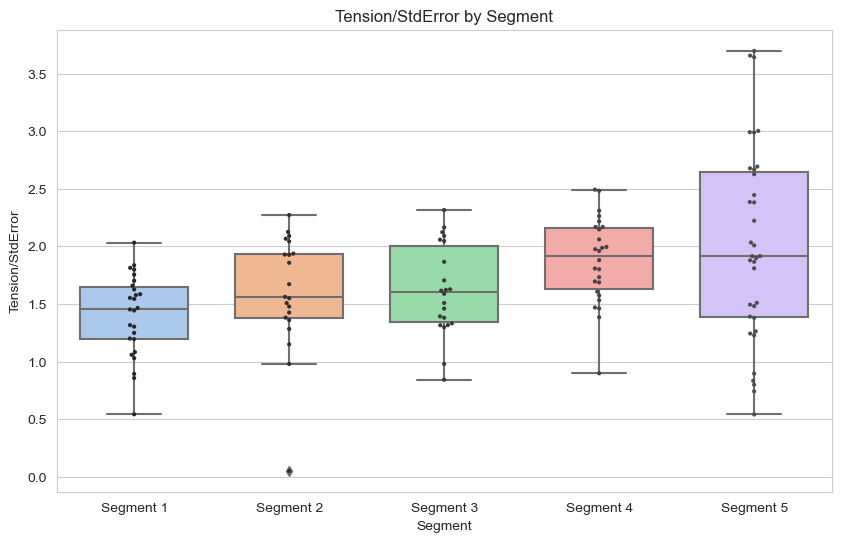

In [125]:
import seaborn as sns

# Crear una lista para almacenar los DataFrames de cada segmento
segment_dfs = []

# Dividir el DataFrame en cinco segmentos basados en la posición X media
for i in range(5):
    df_seg = df[(df['Mid_X'] >= seg_boundaries[i]) & (df['Mid_X'] < seg_boundaries[i+1])].copy()
    
    # Calcular la relación entre la tensión y el error estándar
    df_seg['Tension/StdError'] = df_seg['Tension'] / df_seg['stdError']
    
    # Renombrar la columna de la relación para reflejar el segmento
    segment_name = f'Segment {i+1}'
    df_seg.rename(columns={'Tension/StdError': segment_name}, inplace=True)
    
    segment_dfs.append(df_seg[[segment_name]])

# Concatenar los DataFrames de los segmentos a lo largo del eje de las columnas
df_concat = pd.concat(segment_dfs, axis=1)

# Crear el boxplot con seaborn
plt.figure(figsize=(10,6))
sns.boxplot(data=df_concat, width=0.7, fliersize=5, palette='pastel')

# Añadir los puntos individuales con swarmplot
sns.swarmplot(data=df_concat, size=3, color=".3", linewidth=0)

plt.title('Tension/StdError by Segment')
plt.xlabel('Segment')
plt.ylabel('Tension/StdError')
plt.show()


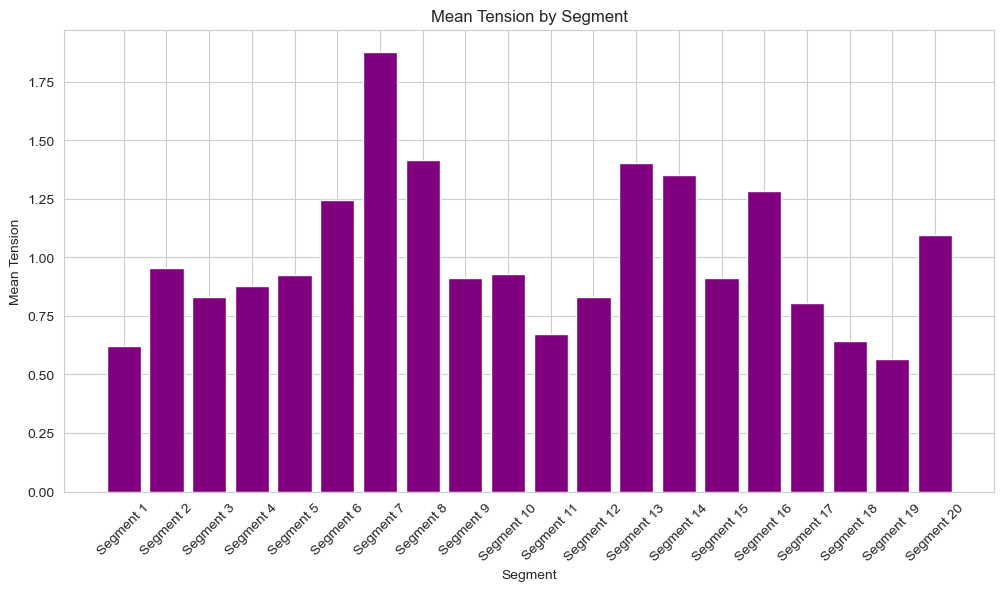

In [124]:
# Identificar el punto más a la izquierda y el más a la derecha usando Mid_X
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()

# Calcular el ancho de cada segmento
segment_width = (max_x - min_x) / 20

# Crear los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(21)]

# Crear una lista para almacenar las medias de tensión de cada segmento
mean_tensions = []

# Dividir el DataFrame en once segmentos basados en la posición X media
for i in range(20):
    df_seg = df[(df['Mid_X'] >= seg_boundaries[i]) & (df['Mid_X'] < seg_boundaries[i+1])]
    # Calcular la tensión promedio para el segmento
    mean_tensions.append(df_seg['Tension'].mean())

# Crear nombres para los segmentos
seg_names = [f'Segment {i+1}' for i in range(20)]

# Crear el gráfico
plt.figure(figsize=(12,6))
plt.bar(seg_names, mean_tensions, color='purple')
plt.xlabel('Segment')
plt.ylabel('Mean Tension')
plt.title('Mean Tension by Segment')
plt.xticks(rotation=45)
plt.show()


# SELECCIONAR

In [40]:
# Duplicamos el dataframe y renombramos las columnas de tal forma
# que podamos concatenarlos después
df1 = df[['CELL1', 'Area_CELL1', 'Tension', 'stdError', 'X1', 'Y1']].copy()
df2 = df[['CELL2', 'Area_CELL2', 'Tension', 'stdError', 'X2', 'Y2']].copy()

df1.columns = ['CELL', 'Area', 'Tension', 'stdError', 'X', 'Y']
df2.columns = ['CELL', 'Area', 'Tension', 'stdError', 'X', 'Y']

# Concatenamos los dataframes
df_concat = pd.concat([df1, df2])

# Agrupamos por CELL y calculamos el área, la media de las tensiones, stdError, y las medias de X e Y.
df_final = df_concat.groupby('CELL').agg({'Area': 'first', 'Tension': np.mean, 'stdError': np.mean, 'X': np.mean, 'Y': np.mean}).reset_index()
print(df_final )
# Añadimos una nueva columna que es la relación entre la tensión y stdError
df_final['Tension/stdError'] = df_final['Tension'] / df_final['stdError']
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import numpy as np

class SelectFromImage(object):
    def __init__(self, ax, data):
        self.ax = ax
        self.data = data
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None
        self.verts = None

    def onselect(self, verts):
        self.verts = verts  # Guardar los vértices seleccionados
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        
        # Crear una columna para indicar si el centroide está dentro del área seleccionada
        self.data['In_Area'] = self.data.apply(lambda row: path.contains_point((row.X, row.Y)), axis=1)
        self.ax.figure.canvas.draw()


fig, ax = plt.subplots(figsize=(10, 10))

# Dibuja los nodos
ax.scatter(df_final['X'], df_final['Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    ax.plot([row['X1'], row['X2']], 
            [row['Y1'], row['Y2']],
            color='blue')

ax.set_title('Visualización del tejido')

lasso_select = SelectFromImage(ax, df_final)
plt.gca().invert_yaxis()
plt.show()

     CELL   Area   Tension  stdError           X           Y
0       1    0.0  0.922777  0.491052  227.245614  124.192982
1       2  169.0  0.867234  0.434461  184.200000   18.800000
2       3  526.0  1.060343  0.458933  201.000000   22.600000
3       4  308.5  1.273194  0.491229  218.500000   17.750000
4       5  447.5  0.827640  0.442072  168.200000   30.600000
..    ...    ...       ...       ...         ...         ...
147   148  468.0  1.096828  0.440259  134.800000  211.800000
148   149  298.0  0.834468  0.463541  190.750000  218.000000
149   150  190.0  0.856496  0.437956  202.500000  211.750000
150   151  229.5  0.477975  0.382220  241.000000  218.000000
151   152   66.5  1.254449  0.506937  285.000000  214.666667

[152 rows x 6 columns]


In [41]:
# Configura el tamaño de la figura para que sea más ancha
df_inside = df_final[df_final['In_Area']]
df_outside = df_final[~df_final['In_Area']]

# Crea subplots
fig, ax = plt.subplots(figsize=(6, 6))

# Ordena los dataframes por tensión
df_inside = df_inside.sort_values('Tension')
df_outside = df_outside.sort_values('Tension')

# Dibuja los puntos para los edges dentro del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_inside)), df_inside['Tension'], yerr=df_inside['stdError'], fmt='o', 
            color='blue', ecolor='black', elinewidth=1, capsize=3, label='- myosin')

# Dibuja los puntos para los edges fuera del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_outside)), df_outside['Tension'], yerr=df_outside['stdError'], fmt='o', 
            color='red', ecolor='black', elinewidth=1, capsize=3, label='= myosin')

# Añade una leyenda
ax.legend(fontsize=18)

# Añade títulos y etiquetas
#ax.set_title('Tension of Edges Inside and Outside Selected Area', fontsize=16)
ax.set_xlabel('Sorted Cell Index', fontsize=18)
ax.set_ylabel('Tension', fontsize=18)

# Ajusta el estilo de los ticks
ax.tick_params(axis='both', which='major', labelsize=18)

# Hace el eje x más largo
#ax.set_xlim(-1, max(len(df_inside), len(df_outside)))
#box_plot.tick_params(axis='x', labelsize=1)
box_plot.tick_params(axis='y', labelsize=18)
plt.show()

In [42]:

import seaborn as sns
from scipy import stats

# Configura el estilo de los plots a 'whitegrid' para un mejor diseño
sns.set_style('whitegrid')

# Combina los dos dataframes en uno con una nueva columna 'Location' para indicar la ubicación de los edges
df_combined = pd.concat([df_outside.assign(Location='= myosin'), df_inside.assign(Location='- myosin')])

# Crea un boxplot con los puntos mostrados
plt.figure(figsize=(6, 6))
box_plot = sns.boxplot(x='Location', y='Tension', data=df_combined, palette='Set1')
sns.stripplot(x='Location', y='Tension', data=df_combined, 
              size=4, color='grey', alpha=0.6, )

# Establece los títulos y etiquetas
#box_plot.set_title('Boxplot of Tension Inside and Outside Selected Area', fontsize=16)
box_plot.set_xlabel('')
box_plot.set_ylabel('Tension', fontsize=18)

# Realiza un test t de Student para comparar las medias
t_stat, p_val = stats.ttest_ind(df_inside['Tension'], df_outside['Tension'], equal_var=False)

# Añade la anotación de significancia al gráfico
significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'

# Define la posición y longitud de la barra de significancia
y_max = max(df_inside['Tension'].max(), df_outside['Tension'].max())
h = y_max * 0.00  # 5% of the maximum y value
bar_start = 0.0
bar_end = 1

# Dibuja la barra de significancia
box_plot.plot([bar_start, bar_start, bar_end, bar_end], 
              [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
              lw=1.5, color='black')
# Añade la anotación
box_plot.text((bar_start + bar_end) / 2, y_max -0.01, 
              f"{significance_code}", 
              ha='center', va='bottom', color='black', fontsize=18)
box_plot.tick_params(axis='x', labelsize=18)
box_plot.tick_params(axis='y', labelsize=18)
plt.show()


# SEELCCIONAR DESDE EDGES

In [4]:
%matplotlib qt
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class SelectFromImage(object):
    def __init__(self, ax):
        self.ax = ax
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None
        self.verts = None

    def onselect(self, verts):
        self.verts = verts  # Guardar los vértices seleccionados
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        self.ax.figure.canvas.draw()



# Define el rango de x y el ancho del segmento
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()
segment_width = (max_x - min_x) / 5

# Define los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(6)]

# Asigna cada borde a un segmento
df['Segment'] = pd.cut(df['Mid_X'], bins=seg_boundaries, labels=[1, 2, 3, 4, 5])
df = df.dropna(subset=['Segment'])

# Define los colores para cada segmento
colors = ['red', 'green', 'blue', 'yellow', 'purple']

fig, ax = plt.subplots(figsize=(10, 10))

# Dibuja los nodos
ax.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    ax.plot([row['X1'], row['X2']], 
            [row['Y1'], row['Y2']],
            color=colors[int(row['Segment'])-1])

ax.set_title('Visualización del tejido')

lasso_select = SelectFromImage(ax)
plt.gca().invert_yaxis()
plt.show()



In [9]:
%matplotlib inline
# Crea un objeto Path utilizando los vértices seleccionados
selected_path = Path(lasso_select.verts)

# Crea una nueva columna en tu DataFrame para almacenar si cada edge está dentro o fuera de la región seleccionada
df['In_Selected_Area'] = selected_path.contains_points(df[['Mid_X', 'Mid_Y']].values)

# Ahora, df['In_Selected_Area'] será True para los edges que estén dentro de la región seleccionada y False para los que estén fuera.


In [10]:
print(df)

     EdgeID     X1     Y1     X2     Y2     Length       Mid_X       Mid_Y  \
0         3  179.0    9.0  185.0    6.0   6.708204  181.592203    6.714530   
1         4  185.0    6.0  205.0   10.0  20.396078  195.148164    6.969137   
2         5  185.0    6.0  189.0   27.0  21.377558  185.893894   16.717293   
3         6  205.0   10.0  228.0   13.0  23.194827  216.695184    8.424230   
4         7  205.0   10.0  213.0   35.0  26.248809  207.529009   22.924050   
..      ...    ...    ...    ...    ...        ...         ...         ...   
442     447  257.0  223.0  247.0  209.0  17.204651  253.916206  214.665112   
443     448  229.0  224.0  230.0  220.0   4.123106  229.507328  222.001832   
444     449  279.0  216.0  296.0  227.0  20.248457  281.732993  227.190774   
445     450  279.0  216.0  288.0  214.0   9.219544  283.373115  214.458919   
446     451  296.0  227.0  288.0  214.0  15.264338  292.430036  220.247577   

             Vector       Angle  CELL1  CELL2  Area_CELL1  Area

NameError: name 'box_plot' is not defined

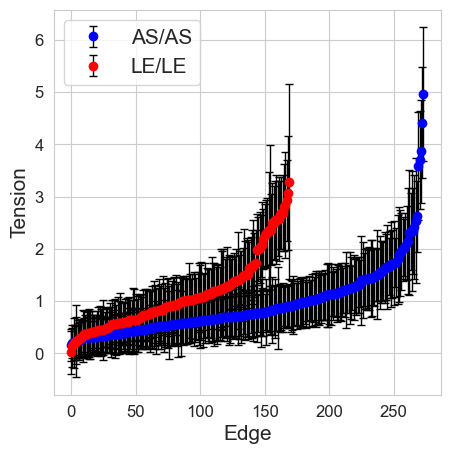

In [11]:
# Configura el tamaño de la figura para que sea más ancha
df_inside = df[df['In_Selected_Area']]
df_outside = df[~df['In_Selected_Area']]

# Crea subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Ordena los dataframes por tensión
df_inside = df_inside.sort_values('Tension')
df_outside = df_outside.sort_values('Tension')

# Dibuja los puntos para los edges dentro del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_inside)), df_inside['Tension'], yerr=df_inside['stdError'], fmt='o', 
            color='blue', ecolor='black', elinewidth=1, capsize=3, label='AS/AS')

# Dibuja los puntos para los edges fuera del área seleccionada, con barras de error
ax.errorbar(np.arange(len(df_outside)), df_outside['Tension'], yerr=df_outside['stdError'], fmt='o', 
            color='red', ecolor='black', elinewidth=1, capsize=3, label='LE/LE')

# Añade una leyenda
ax.legend(fontsize=15)

# Añade títulos y etiquetas
#ax.set_title('Tension of Edges Inside and Outside Selected Area', fontsize=16)
ax.set_xlabel('Edge', fontsize=15)
ax.set_ylabel('Tension', fontsize=15)

# Ajusta el estilo de los ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Hace el eje x más largo
#ax.set_xlim(-1, max(len(df_inside), len(df_outside)))
box_plot.tick_params(axis='x', labelsize=1)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()


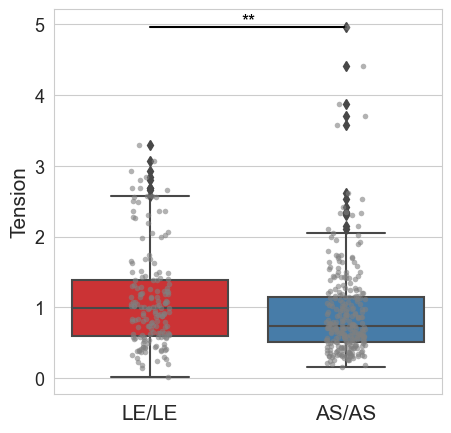

In [12]:
import seaborn as sns
from scipy import stats

# Configura el estilo de los plots a 'whitegrid' para un mejor diseño
sns.set_style('whitegrid')

# Combina los dos dataframes en uno con una nueva columna 'Location' para indicar la ubicación de los edges
df_combined = pd.concat([df_outside.assign(Location='LE/LE'), df_inside.assign(Location='AS/AS')])

# Crea un boxplot con los puntos mostrados
plt.figure(figsize=(5, 5))
box_plot = sns.boxplot(x='Location', y='Tension', data=df_combined, palette='Set1')
sns.stripplot(x='Location', y='Tension', data=df_combined, 
              size=4, color='grey', alpha=0.6, )

# Establece los títulos y etiquetas
#box_plot.set_title('Boxplot of Tension Inside and Outside Selected Area', fontsize=16)
box_plot.set_xlabel('')
box_plot.set_ylabel('Tension', fontsize=15)

# Realiza un test t de Student para comparar las medias
t_stat, p_val = stats.ttest_ind(df_inside['Tension'], df_outside['Tension'], equal_var=False)

# Añade la anotación de significancia al gráfico
significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '.' if p_val < 0.1 else 'ns'

# Define la posición y longitud de la barra de significancia
y_max = max(df_inside['Tension'].max(), df_outside['Tension'].max())
h = y_max * 0.00  # 5% of the maximum y value
bar_start = 0.0
bar_end = 1

# Dibuja la barra de significancia
box_plot.plot([bar_start, bar_start, bar_end, bar_end], 
              [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
              lw=1.5, color='black')
# Añade la anotación
box_plot.text((bar_start + bar_end) / 2, y_max -0.05, 
              f"{significance_code}", 
              ha='center', va='bottom', color='black', fontsize=13)
box_plot.tick_params(axis='x', labelsize=15)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()

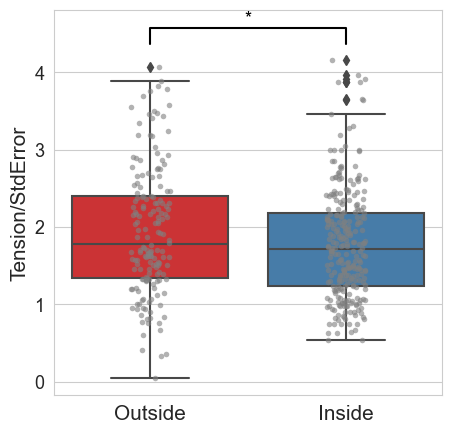

In [13]:
import seaborn as sns
from scipy import stats

# Configura el estilo de los plots a 'whitegrid' para un mejor diseño
sns.set_style('whitegrid')

# Crear la columna 'Tension/StdError' en ambos dataframes
df_inside['Tension/StdError'] = df_inside['Tension'] / df_inside['stdError']
df_outside['Tension/StdError'] = df_outside['Tension'] / df_outside['stdError']

# Combina los dos dataframes en uno con una nueva columna 'Location' para indicar la ubicación de los edges
df_combined = pd.concat([df_outside.assign(Location='Outside'), df_inside.assign(Location='Inside')])

# Crea un boxplot con los puntos mostrados
plt.figure(figsize=(5, 5))
box_plot = sns.boxplot(x='Location', y='Tension/StdError', data=df_combined, palette='Set1')
sns.stripplot(x='Location', y='Tension/StdError', data=df_combined, 
              size=4, color='grey', alpha=0.6)

# Establece los títulos y etiquetas
box_plot.set_xlabel('')
box_plot.set_ylabel('Tension/StdError', fontsize=15)

# Realiza un test t de Student para comparar las medias
t_stat, p_val = stats.ttest_ind(df_inside['Tension/StdError'], df_outside['Tension/StdError'], equal_var=False)

# Añade la anotación de significancia al gráfico
significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '.' if p_val < 0.1 else 'ns'

# Define la posición y longitud de la barra de significancia
y_max = max(df_inside['Tension/StdError'].max(), df_outside['Tension/StdError'].max())
h = y_max * 0.05  # 5% of the maximum y value
bar_start = 0.0
bar_end = 1

# Dibuja la barra de significancia
box_plot.plot([bar_start, bar_start, bar_end, bar_end], 
              [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
              lw=1.5, color='black')
# Añade la anotación
box_plot.text((bar_start + bar_end) / 2, y_max + 2*h, 
              f"{significance_code}", 
              ha='center', va='bottom', color='black', fontsize=13)
box_plot.tick_params(axis='x', labelsize=15)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()


# DOBLE SELECCION DE AREA

In [2]:
%matplotlib qt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.widgets import LassoSelector
from matplotlib.patches import PathPatch

class SelectFromImage:
    def __init__(self, ax):
        self.ax = ax
        self.lasso = LassoSelector(ax, self.onselect)
        self.areas = []

    def onselect(self, verts):
        path = Path(verts)
        patch = PathPatch(path, facecolor='none', edgecolor='red', alpha=0.6)
        self.ax.add_patch(patch)
        self.areas.append(path)
        plt.draw()

def classify_point(point, areas):
    if len(areas) < 2:
        return "N/A" # Return 'N/A' if less than two areas are selected
    if areas[0].contains_point(point):
        return "LE/LE"
    elif areas[1].contains_point(point):
        return "AS/AS"
    else:
        return "LE/AS"

# Plot the data
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Initialize lasso selector
lasso = SelectFromImage(ax)

# Invert Y-axis (if necessary)
plt.gca().invert_yaxis()

# Show the plot
plt.show()



In [3]:
if len(lasso.areas) < 2:
    print("Please make sure to select two areas using the Lasso before running the classification code.")
else:
    # Classify the points after selection
    df['Classification'] = df[['Mid_X', 'Mid_Y']].apply(lambda row: classify_point((row['Mid_X'], row['Mid_Y']), lasso.areas), axis=1)
    # Print or further analyze 'df' with the 'Classification' column
    print(df)


     EdgeID     X1     Y1     X2     Y2     Length       Mid_X       Mid_Y  \
0         9  253.0   20.0  256.0   40.0  20.223748  253.025549   30.198966   
1        11  259.0   20.0  260.0   39.0  19.026298  258.793173   29.524115   
2        15  210.0   21.0  210.0   31.0  10.000000  211.180340   26.000000   
3        16  216.0   21.0  217.0   35.0  14.035669  217.355570   27.924758   
4        20  246.0   21.0  247.0   35.0  14.035669  247.179866   27.963363   
..      ...    ...    ...    ...    ...        ...         ...         ...   
427     520  182.0  176.0  174.0  181.0   9.433981  178.115706  178.677818   
428     521  176.0  200.0  174.0  181.0  19.104973  173.701929  190.666334   
429     523  335.0  179.0  336.0  179.0   1.000000  335.500000  179.000093   
430     524  292.0  192.0  304.0  186.0  13.416408  298.601286  190.221835   
431     525  335.0  179.0  304.0  186.0  31.780497  320.127650  185.742490   

            Vector       Angle  CELL1  CELL2  Area_CELL1  Area_

In [9]:
# Divide el DataFrame en tres partes según la clasificación
df_le_le = df[df['Classification'] == 'LE/LE']
df_as_as = df[df['Classification'] == 'AS/AS']
df_le_as = df[df['Classification'] == 'LE/AS']

# Crea subplots
fig, ax = plt.subplots(figsize=(6, 6))

# Ordena los dataframes por tensión
df_le_le = df_le_le.sort_values('Tension')
df_as_as = df_as_as.sort_values('Tension')
df_le_as = df_le_as.sort_values('Tension')

# Dibuja los puntos para los edges clasificados como LE/LE, con barras de error
ax.errorbar(np.arange(len(df_le_le)), df_le_le['Tension'], yerr=df_le_le['stdError'], fmt='o', 
            color='red', ecolor='black', elinewidth=1, capsize=3, label='LE-LE')

# Dibuja los puntos para los edges clasificados como AS/AS, con barras de error
ax.errorbar(np.arange(len(df_as_as)), df_as_as['Tension'], yerr=df_as_as['stdError'], fmt='o', 
            color='blue', ecolor='black', elinewidth=1, capsize=3, label='AS-AS')

# Dibuja los puntos para los edges clasificados como LE/AS, con barras de error
ax.errorbar(np.arange(len(df_le_as)), df_le_as['Tension'], yerr=df_le_as['stdError'], fmt='o', 
            color='green', ecolor='black', elinewidth=1, capsize=3, label='LE-AS')

# Añade una leyenda
ax.legend(fontsize=15)

# Añade títulos y etiquetas
ax.set_xlabel('Sorted Edge Index', fontsize=15)
ax.set_ylabel('Edge Tension \u00B1 stdError ', fontsize=15)

# Ajusta el estilo de los ticks
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='both', linewidth=0.5)
ax.set_xticks(np.arange(0, max(np.arange(len(df_le_le)))+1, 50))
# Hace el eje x más largo
#plt.xticks(np.arange(min(np.arange(len(df_le_le))), max(np.arange(len(df_le_le))), 10.0))

plt.show()


In [24]:
import seaborn as sns
from scipy import stats

# Divide el DataFrame en tres partes según la clasificación
df_le_le = df[df['Classification'] == 'LE/LE']
df_as_as = df[df['Classification'] == 'AS/AS']
df_le_as = df[df['Classification'] == 'LE/AS']

# Combina los tres dataframes en uno con una nueva columna 'Classification' para indicar la clasificación de los edges
df_combined = pd.concat([
    df_le_le.assign(Classification='LE-LE'), 
    df_as_as.assign(Classification='AS-AS'),
    df_le_as.assign(Classification='LE-AS')
])

# Crea un boxplot con los puntos mostrados
fig, ax = plt.subplots(figsize=(6, 6))

ax.yaxis.grid(True, which='major', color='grey', alpha=0.5)
ax.set_axisbelow(True)

box_plot = sns.boxplot(x='Classification', y='Tension', data=df_combined, palette='Set1')
sns.stripplot(x='Classification', y='Tension', data=df_combined, 
              size=4, color='grey', alpha=0.6)

# Define las posiciones y longitudes de las barras de significancia
y_max = df_combined['Tension'].max()
h = y_max * 0.05
bar_positions = [(0, 1), (1, 2), (0, 2)]  # Pairwise comparisons

# Realiza pruebas t de Student y añade las anotaciones de significancia
for start, end in bar_positions:
    t_stat, p_val = stats.ttest_ind(df_combined['Tension'][df_combined['Classification'] == df_combined['Classification'].unique()[start]],
                                    df_combined['Tension'][df_combined['Classification'] == df_combined['Classification'].unique()[end]],
                                    equal_var=False)
    significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '.' if p_val < 0.1 else 'ns'
    box_plot.plot([start, start, end, end], 
                  [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
                  lw=1.5, color='black')
    box_plot.text((start + end) / 2, y_max + 2 * h, 
                  f"{significance_code}", 
                  ha='center', va='bottom', color='black', fontsize=13)

# Define los títulos y etiquetas
box_plot.set_xlabel('')
box_plot.set_ylabel('Tension', fontsize=15)
box_plot.tick_params(axis='x', labelsize=15)
box_plot.tick_params(axis='y', labelsize=13)


plt.show()


In [ ]:
###### import pandas as pd

# Suponiendo que df es tu DataFrame original
df_cell1 = df[['CELL1', 'Pressure1', 'Classification']].copy()
df_cell1.rename(columns={'CELL1': 'Cell_ID', 'Pressure1': 'Pressure'}, inplace=True)

df_cell2 = df[['CELL2', 'Pressure2', 'Classification']].copy()
df_cell2.rename(columns={'CELL2': 'Cell_ID', 'Pressure2': 'Pressure'}, inplace=True)

# Concatenar los dos DataFrames para obtener uno con todos los cell_id, su presión y su clasificación
final_df = pd.concat([df_cell1, df_cell2], ignore_index=True)

# Si quieres eliminar posibles duplicados
final_df.drop_duplicates(inplace=True)

# Resultado
print(final_df)


In [12]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Divide el DataFrame en dos partes según la clasificación
df_as_as = final_df[final_df['Classification'] == 'AS/AS']
df_le_le = final_df[final_df['Classification'] == 'LE/LE']

# Combina los dos dataframes en uno con una nueva columna 'Classification' para indicar la clasificación de los edges
df_combined = pd.concat([
    df_as_as.assign(Classification='AS-AS'),
    df_le_le.assign(Classification='LE-LE')
])

# Crea un boxplot con los puntos mostrados
plt.figure(figsize=(5, 5))
box_plot = sns.boxplot(x='Classification', y='Pressure', data=df_combined, palette='Set1')
sns.stripplot(x='Classification', y='Pressure', data=df_combined, 
              size=4, color='grey', alpha=0.6)

# Realiza un test t de Student y añade la anotación de significancia
t_stat, p_val = stats.ttest_ind(df_as_as['Pressure'], df_le_le['Pressure'], equal_var=False)
significance_code = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else '.' if p_val < 0.1 else 'ns'
y_max = df_combined['Pressure'].max()
h = y_max * 0.05
box_plot.plot([0, 0, 1, 1], 
              [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], 
              lw=1.5, color='black')
box_plot.text(0.5, y_max + 2.5 * h, 
              f"{significance_code}", 
              ha='center', va='bottom', color='black', fontsize=13)

# Define los títulos y etiquetas
box_plot.set_xlabel('')
box_plot.set_ylabel('Pressure', fontsize=15)
box_plot.tick_params(axis='x', labelsize=15)
box_plot.tick_params(axis='y', labelsize=13)
plt.show()


# STRESS

In [2]:
# Let's create a dictionary for cells with EdgeIDs and Area.
cell_dict = {}

for index, row in df.iterrows():
    for cell_number in ['CELL1', 'CELL2']:
        cell_id = row[cell_number]
        if not math.isnan(cell_id):  # Check if cell_id is not NaN
            cell_id = int(cell_id)
            if cell_id in cell_dict:
                cell_dict[cell_id]['edges'].append(row['EdgeID'])
            else:
                cell_dict[cell_id] = {'edges': [row['EdgeID']], 'area': row['Area_' + cell_number]}

# Now we can convert this dictionary into a DataFrame.
cell_df = pd.DataFrame.from_dict(cell_dict, orient='index')
cell_df.index.name = 'CellID'
cell_df.reset_index(inplace=True)

# Initialize two new columns to store the centroid coordinates
cell_df['centroid_x'] = np.nan
cell_df['centroid_y'] = np.nan

# Iterate over each cell
for i, row in cell_df.iterrows():
    edge_ids = row['edges']  # Get the edge IDs of the current cell
    
    # Filter the edges DataFrame to keep only the edges that belong to the current cell
    edges_of_cell = df[df['EdgeID'].isin(edge_ids)]
    
    # Calculate the centroid coordinates as the mean of the nodes coordinates
    centroid_x = edges_of_cell[['X1', 'X2']].mean(axis=1).mean()
    centroid_y = edges_of_cell[['Y1', 'Y2']].mean(axis=1).mean()
    
    # Update the centroid coordinates of the current cell in the cells DataFrame
    cell_df.at[i, 'centroid_x'] = centroid_x
    cell_df.at[i, 'centroid_y'] = centroid_y

print(cell_df)

     CellID              edges   area  centroid_x  centroid_y
0         7  [9, 11, 115, 124]   99.5  257.500000   34.750000
1         6   [9, 20, 77, 123]  148.5  251.375000   34.375000
2         8  [11, 27, 71, 116]  106.0  262.625000   34.000000
3        10   [15, 16, 56, 69]   81.5  213.250000   30.250000
4         4       [15, 55, 58]   61.0  207.833333   29.833333
..      ...                ...    ...         ...         ...
164     173    [507, 508, 509]  743.0  263.000000  180.166667
165     174         [511, 512]  471.5  352.500000  172.500000
166     175    [515, 516, 517]  215.5  121.500000  175.833333
167     176    [519, 520, 521]  243.0  180.500000  182.000000
168     177    [523, 524, 525]  286.5  317.666667  183.500000

[169 rows x 5 columns]


In [3]:
def calculate_stress_tensor(cell_id, cell_area, edge_ids, df, total_area, p=0.02):  # Assuming constant pressure p
    stress_tensor = np.zeros((2, 2))
    for edge_id in edge_ids:
        edge = df[df['EdgeID'] == edge_id].iloc[0]
        vector_ij = np.array([edge['X2'] - edge['X1'], edge['Y2'] - edge['Y1']])
        T = edge['Tension']
        stress_tensor += T * np.outer(vector_ij, vector_ij) / np.linalg.norm(vector_ij)
    stress_tensor -= np.abs(p) * cell_area * np.eye(2)
    stress_tensor=stress_tensor/total_area
    eigenvalues, eigenvectors = np.linalg.eig(stress_tensor)
    return stress_tensor, eigenvalues, eigenvectors

total_area = cell_df['area'].sum()
# Apply function to each cell
results = []
for index, row in cell_df.iterrows():
    stress_tensor, eigenvalues, eigenvectors = calculate_stress_tensor(row['CellID'], row['area'], row['edges'], df,total_area)
    results.append({
        'CellID': row['CellID'],
        'StressTensor': stress_tensor,
        'Eigenvalues': eigenvalues,
        'Eigenvectors': eigenvectors
    })

# Convert results into a dataframe
results_df = pd.DataFrame(results)
#results_df['NormalizedStressTensor'] = results_df['StressTensor'].apply(lambda x: x / total_area)


<IPython.core.display.Javascript object>


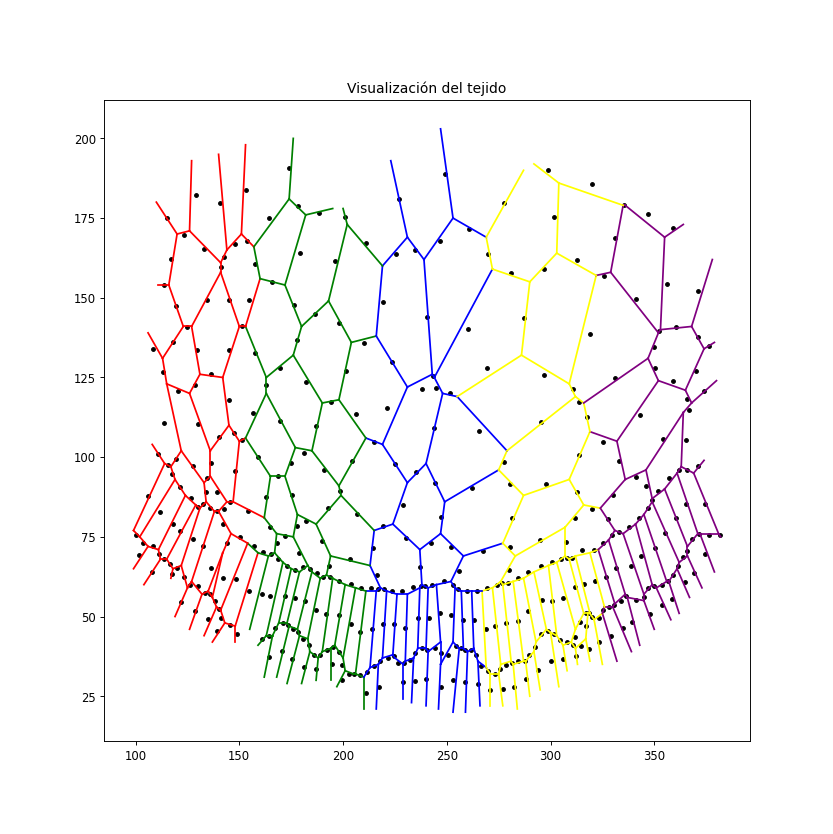

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path
from matplotlib.patches import PathPatch

class SelectFromImage(object):
    def __init__(self, ax):
        self.ax = ax
        self.selector = LassoSelector(ax, self.onselect)
        self.poly = None
        self.verts = None

    def onselect(self, verts):
        self.verts = verts  # Guardar los vértices seleccionados
        self.selector.set_active(False)  # Desactivar el selector después de la selección

        if self.poly is not None:
            self.poly.remove()

        path = Path(verts)
        self.poly = PathPatch(path, alpha=0.3)
        self.ax.add_patch(self.poly)
        self.ax.figure.canvas.draw()



# Define el rango de x y el ancho del segmento
min_x = df['Mid_X'].min()
max_x = df['Mid_X'].max()
segment_width = (max_x - min_x) / 5

# Define los límites de los segmentos
seg_boundaries = [min_x + i * segment_width for i in range(6)]

# Asigna cada borde a un segmento
df['Segment'] = pd.cut(df['Mid_X'], bins=seg_boundaries, labels=[1, 2, 3, 4, 5])
df = df.dropna(subset=['Segment'])
# Define los colores para cada segmento
colors = ['red', 'green', 'blue', 'yellow', 'purple']

fig, ax = plt.subplots(figsize=(10, 10))

# Dibuja los nodos
ax.scatter(df['Mid_X'], df['Mid_Y'], color='black', s=10)

# Dibuja los bordes y los colorea basándose en el segmento
for _, row in df.iterrows():
    ax.plot([row['X1'], row['X2']], 
            [row['Y1'], row['Y2']],
            color=colors[int(row['Segment'])-1])

ax.set_title('Visualización del tejido')

lasso_select = SelectFromImage(ax)
plt.show()


In [4]:
print(results_df)

     CellID                                       StressTensor  \
0         7  [[-1.880966945719483e-05, 6.246000274129411e-0...   
1         6  [[-3.80413801944166e-05, 2.0898845997323274e-0...   
2         8  [[-2.7152297103819855e-05, -3.5081281906667508...   
3        10  [[0.00015219745154241527, 0.000124559572385998...   
4         4  [[0.00021419038616963523, -4.768834176689576e-...   
..      ...                                                ...   
164     173  [[0.00046843488216042706, -4.3400264810104676e...   
165     174  [[0.0006750169468795561, -0.000150877562865892...   
166     175  [[0.0006298412131130462, -0.000272767574983111...   
167     176  [[0.0008263708348323316, -1.4083636984816414e-...   
168     177  [[0.002369352132957418, -0.0007739914708804252...   

                                          Eigenvalues  \
0    [-1.9151626798540852e-05, 9.527625503520765e-05]   
1    [-4.037096808930807e-05, 0.00014944318090654433]   
2    [-2.729441955665713e-05, 5.9441

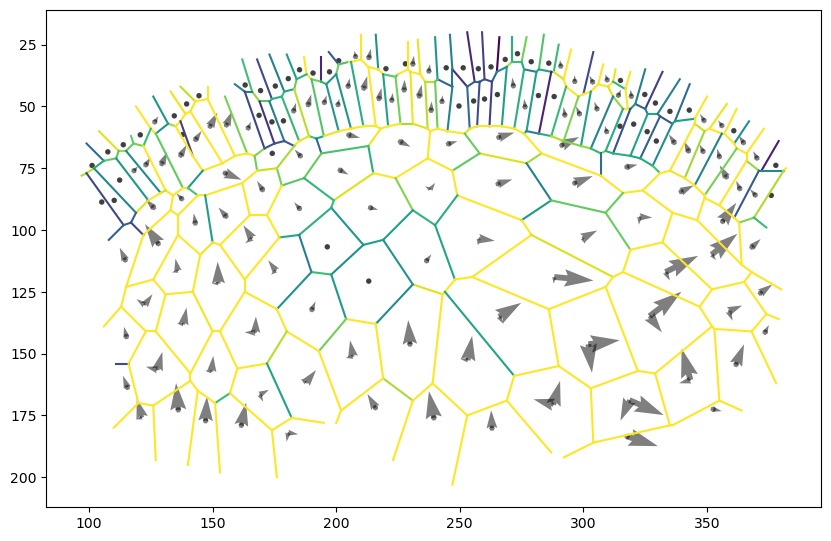

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 10))
# Plotting the edges for each cell
# Draw each edge
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], [row['Y1'], row['Y2']], color=plt.cm.viridis(row['Tension']))

# Add a color bar to show the scale of tension
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['Tension'].min(), vmax=df['Tension'].max()))
#plt.colorbar(sm)
# Plot each cell's stress vector
for _, cell in cell_df.iterrows():
    cell_id = cell['CellID']
    result_row = results_df[results_df['CellID'] == cell_id].iloc[0]

    # Get eigenvectors and eigenvalues
    eigenvectors = np.array(result_row['Eigenvectors'])
    eigenvalues = np.array(result_row['Eigenvalues'])
    #stress_vectors=np.array(result_row['NormalizedStressTensor'])
    
    # Calculate the stress vectors
    stress_vectors = eigenvectors * eigenvalues[:, np.newaxis]*5000
    
    # There are two stress vectors per cell, let's plot them both
    for vector in stress_vectors:
        ax.quiver(cell['centroid_x'], cell['centroid_y'], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, alpha=0.5)

ax.set_aspect('equal')  # Equal scaling in both axis
plt.gca().invert_yaxis()
plt.show()


NameError: name 'Ellipse' is not defined

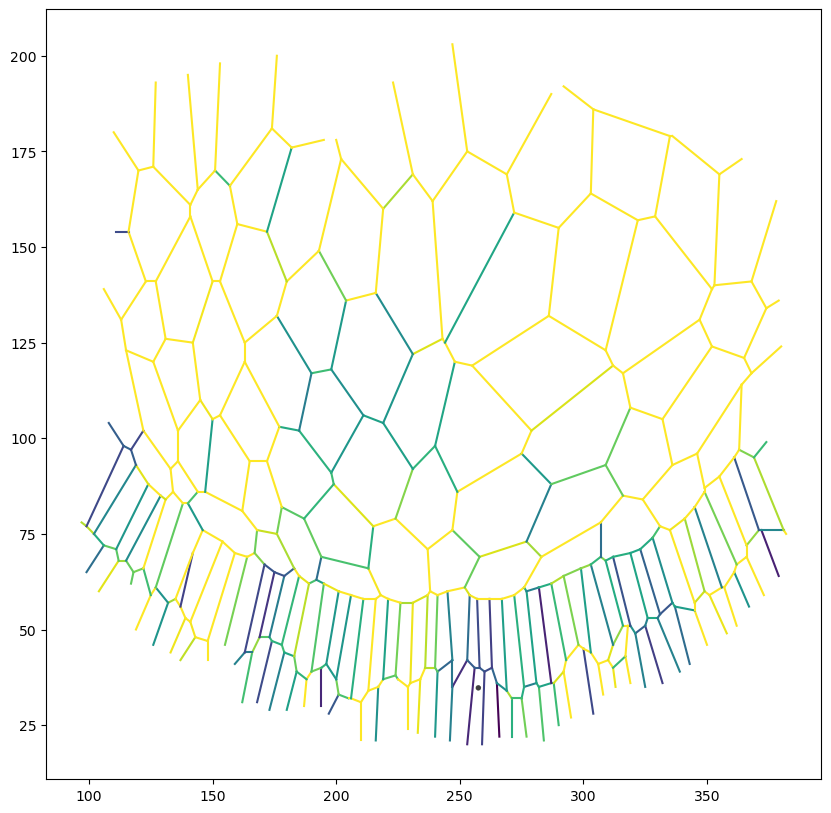

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

# Dibujar cada arista
for _, row in df.iterrows():
    plt.plot([row['X1'], row['X2']], [row['Y1'], row['Y2']], color=plt.cm.viridis(row['Tension']))

# Añadir una barra de color para mostrar la escala de tensión
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['Tension'].min(), vmax=df['Tension'].max()))
#plt.colorbar(sm)

# Dibujar el vector de estrés de cada célula y la elipse correspondiente
for _, cell in cell_df.iterrows():
    cell_id = cell['CellID']
    result_row = results_df[results_df['CellID'] == cell_id].iloc[0]

    # Obtener los eigenvectores y los eigenvalores
    eigenvectors = np.array(result_row['Eigenvectors'])
    eigenvalues = np.array(result_row['Eigenvalues'])
    
    # Calcular los vectores de tensión
    stress_vectors = eigenvectors * eigenvalues[:, np.newaxis]*3000
    
    # Hay dos vectores de tensión por célula, vamos a dibujarlos ambos
    for vector in stress_vectors:
        ax.quiver(cell['centroid_x'], cell['centroid_y'], vector[0], vector[1], angles='xy', scale_units='xy', scale=1, alpha=0.5)
    
    # Obtener el índice del vector más grande y el más pequeño
    max_vector_index = np.argmax(eigenvalues)
    min_vector_index = np.argmin(eigenvalues)
    
    # Calcular los ángulos de los eigenvectores
    angles = np.arctan2(eigenvectors[:, 1], eigenvectors[:, 0])

    # Crear una elipse con los eigenvalores como longitud de los ejes y los ángulos de los eigenvectores como orientación
    ellipse = Ellipse((cell['centroid_x'], cell['centroid_y']), 
                      width=eigenvalues[max_vector_index]*6000, 
                      height=eigenvalues[min_vector_index]*6000, 
                      angle=np.degrees(angles[max_vector_index]), 
                      fill=False, 
                      color='green')

    ax.add_patch(ellipse)

ax.set_aspect('equal')  # Escala igual en ambos ejes
plt.gca().invert_yaxis()
plt.show()
